<p><img alt="Colaboratory logo" height="65px" src="https://upload.wikimedia.org/wikipedia/en/thumb/b/b1/Davivienda_logo.svg/1200px-Davivienda_logo.svg.png" align="left" hspace="10px" width="20%" vspace="15px"></p>

<h1 align="center"> Prueba Técnica Departamento de Datos no Estructurados  </h1>


<p style=»text-align: justify;»>
El Departamento de Analítica No estructurada busca profesionales con fuertes capacidades técnicas y sobretodo una fuerte capacidad analítica. Por consiguiente esta prueba intenta poner a prueba la forma en la que plantea y soluciona problmeas. Es importante que presente el código que usa para resolver el problema con el único motivo de medir sus capacidades.

Se recomienda que sea ordenado en su código y siga los lineamientos establecidos, aún así la prueba tiene un grado de flexibilidad. Se evaluará el orden y la creatividad a la hora de presentar la información. 
</p>


**Nota** <br>
Tenga en cuneta que éste ejercicio es hipotético y el banco no usará su trabajo más que para evaluar sus habiliadades para el cargo


#### **Objetivo**
El objetivo de esta prueba es lograr un filtro que discrimine automáticamente un tipo de documento sin información relevante: páginas en blanco. Se busca que este filtro reciba como entrada una carpeta con imágenes de documentos diversos y produzca como salida dos carpetas, una con imágenes de páginas en blanco y otra con imágenes de páginas con contenido.

Páginas con solo el membrete del documento se consideran páginas en blanco, así como las que, al momento de ser escaneadas, alcanzan a reflejar contenido ininteligible del reverso de la página.

## Clasificación de Imágenes

### 1.Importación de librerías

#### Nota:
Antes de ejecutar este cuaderno, asegúrese de haber instalado las dependencias necesarias. Puede instalarlas utilizando el archivo de requisitos `requirements.txt`.

```bash
pip install -r requirements.txt


In [1]:
import os
import glob

import numpy as np
import cv2

# import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from keras.utils import to_categorical  # Encode labels from text to integers.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


from keras.applications.vgg16 import VGG16
from sklearn.ensemble import RandomForestClassifier  # RANDOM FOREST
from sklearn.metrics import accuracy_score, confusion_matrix

### 2. Paso Previo: División de conjunto de datos

Esta división se realizó de manera manual conservando una proporción 80% para train y 20% para validation. Para posteriormente aplicar la respectiva preparación y etiquetado automático de los datos como se explica en el paso 3.

### 3. Preparación de los datos

En esta sección se definen las siguentes funciones auxiliares que permiten: la importación del dataset, etiquetado de cada imagen según su categoría(docs_con_contenido o docs_sin_contenido), transformaciones a las imagenes que permiten que estén en el formato adecuado y sus dimensiones para facilitar su procesamieto.

In [2]:
# Esta función carga imágenes desde una carpeta dada, redimensiona cada imagen a un tamaño específico
# y realiza algunas transformaciones necesarias en las imágenes antes de devolverlas.
def load_images_from_folder(folder, size_x, size_y):
    images = []
    labels = []
    # Iterar sobre todas las subcarpetas dentro de la carpeta dada
    for directory_path in glob.glob(folder + "/*"):
        # Extraer la etiqueta de la subcarpeta actual
        label = directory_path.split(os.path.sep)[-1]
        # Iterar sobre todas las imágenes dentro de la subcarpeta actual
        for img_path in glob.glob(os.path.join(directory_path, "*.png")):
            # Leer la imagen utilizando OpenCV
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            # Redimensionar la imagen a un tamaño específico (size_x, size_y)
            img = cv2.resize(img, (size_y, size_x))
            # Convertir el espacio de color de la imagen de RGB a BGR
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            # Agregar la imagen a la lista de imágenes
            images.append(img)
            # Agregar la etiqueta correspondiente a la lista de etiquetas
            labels.append(label)
    # Devolver las imágenes y las etiquetas como matrices numpy
    return np.array(images), np.array(labels)


# Esta función toma una lista de etiquetas y las codifica numéricamente usando LabelEncoder de scikit-learn.
def preprocess_labels(labels):
    le = preprocessing.LabelEncoder()
    # Ajustar el codificador de etiquetas a las etiquetas proporcionadas
    le.fit(labels)
    # Transformar las etiquetas en sus representaciones numéricas y devolver el codificador de etiquetas
    return le.transform(labels), le


# Esta función toma una lista de etiquetas codificadas numéricamente y las convierte en representaciones one-hot.
def one_hot_encode_labels(labels):
    return to_categorical(labels)


# Esta función normaliza las imágenes dividiendo todos los valores de píxeles entre 255.0 para escalarlos entre 0 y 1.
def normalize_images(images):
    return images / 255.0


# Constantes
SIZE = 256
TRAIN_DIR = "images/train"
VALIDATION_DIR = "images/validation"

print(os.listdir("images/"))

# Cargar datos
train_images, train_labels = load_images_from_folder(TRAIN_DIR, SIZE, SIZE)
test_images, test_labels = load_images_from_folder(VALIDATION_DIR, SIZE, SIZE)

# Preprocesar etiquetas
train_labels_encoded, le = preprocess_labels(train_labels)
test_labels_encoded, _ = preprocess_labels(test_labels)

# Normalizar imágenes
x_train, x_test = normalize_images(train_images), normalize_images(test_images)

# Codificar etiquetas
y_train_one_hot = one_hot_encode_labels(train_labels_encoded)
y_test_one_hot = one_hot_encode_labels(test_labels_encoded)

['train', 'validation']


### 4. Extracción de características
Se aplican técnicas de extracción de características para mejorar el rendimiento del modelo, teniendo en cuenta que permiten reducir de manera eficiente el tamaño de los datos, al extraer las mejores características posibles de las imágenes (como por ejemplo colores, bordes o formas). En este caso se hace uso de las primeras capas del modelo VGG16 el cual es un modelo preentrenado que se basa en redes neuronales convolucionales (CNN), diseñado específicamente para la clasificaciónn de imágenes.

In [3]:
def extract_features(model, images):
    features = model.predict(images)
    return features.reshape(features.shape[0], -1)

# Modelo VGG16 para extracción de características
VGG_model = VGG16(
    weights="imagenet", include_top=False, input_shape=(SIZE, SIZE, 3)
)
for layer in VGG_model.layers:
    layer.trainable = False
VGG_model.summary()

# Extracción de características
X_for_RF = extract_features(VGG_model, x_train)
X_test_features = extract_features(VGG_model, x_test)



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

### 5. Selección y entrenamiento del modelo
Se selecciona el modelo de Random Forest, teniendo en cuenta que hace parte de las técnicas de árbol de decisión, las cuales se consideran uno de los métodos más conocidos para la clasificación de datos. Además el Random Forest tiende a ser menos propenso al sobreajuste en comparación con otros modelos más complejos, como las redes neuronales profundas, especialmente cuando se cuenta con conjuntos de datos relativamente pequeños, como en este caso que el dataset solo tiene 247 imágenes.

In [4]:
# Entrenamiento con Random Forest
RF_model = RandomForestClassifier()
RF_model.fit(X_for_RF, train_labels_encoded)

RandomForestClassifier()

### 6. Evaluación del modelo

El modelo previamente entrenado se evaluó utilizando la métrica de accuracy.

Accuracy =  1.0


<Axes: >

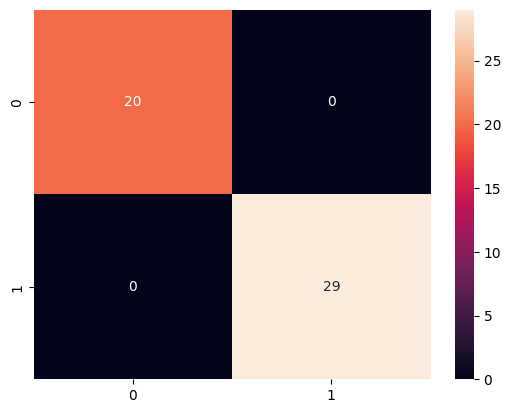

In [5]:
# Predicción y evaluación
prediction_RF = RF_model.predict(X_test_features)
prediction_RF = le.inverse_transform(prediction_RF)
print("Accuracy = ", accuracy_score(test_labels, prediction_RF))

# Matriz de confusión
cm = confusion_matrix(test_labels, prediction_RF)
sns.heatmap(cm, annot=True)

### 7. Exportar modelo entrenado
Se exporta el modelo previamente entrenado para su posterior uso en fase productiva

In [6]:
# Exportar modelo VGG16, Random Forest y Label Encoder
import joblib

joblib.dump(VGG_model, "VGG_model.pkl")
joblib.dump(RF_model, "RF_model.pkl")
joblib.dump(le, "label_encoder.pkl")

print("Modelo exportado")

Modelo exportado


### 8. Aplicación del filtro

En esta sección se implementa una función auxiliar que utiliza el modelo previante entrenado para realizar la clasificación de una imagen llamada predict_image. Adicionalmente, se agrega la función que filtra las imagenes, este filtro recibe como entrada una carpeta con imágenes de documentos diversos y produzca como salida dos carpetas, una con imágenes de páginas sin contenido y otra con imágenes de páginas con contenido.

In [7]:
def predict_image(image_path, model_vgg, model_rf, le, size_x=SIZE, size_y=SIZE):
    """
    Procesa una imagen y realiza una predicción con el modelo entrenado.

    Parámetros:
        image_path (str): Ruta de la imagen a predecir.
        model_vgg (Model): Modelo VGG16 preentrenado para extracción de características.
        model_rf (RandomForestClassifier): Modelo Random Forest entrenado.
        le (LabelEncoder): Codificador de etiquetas utilizado en las etiquetas de entrenamiento.
        size_x (int): Altura deseada de la imagen para el modelo.
        size_y (int): Ancho deseado de la imagen para el modelo.

    Retorna:
        str: La etiqueta predicha para la imagen.
    """
    # Cargar y preprocesar la imagen
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (size_y, size_x))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = np.expand_dims(img, axis=0)  # Añadir una dimensión para el batch
    img = img / 255.0  # Normalizar

    # Extraer características con VGG16
    features = model_vgg.predict(img)
    features = features.reshape(features.shape[0], -1)

    # Predicción con Random Forest
    prediction = model_rf.predict(features)

    # Decodificar la etiqueta
    label_predicted = le.inverse_transform(prediction)[0]

    return label_predicted

In [8]:
import os
import shutil
import joblib
import cv2
import numpy as np

#importar modelos y etiquetas
VGG_model = joblib.load("VGG_model.pkl")
RF_model = joblib.load("RF_model.pkl")
le = joblib.load("label_encoder.pkl")


# Define el tamaño al que deseas redimensionar las imágenes
SIZE = 256

# Ruta de la carpeta que contiene las imágenes a clasificar
total_folder_path = "total/"

# Crear carpetas para las clases predichas por RF
blanco_folder = "docs_sin_contenido/"
documento_folder = "docs_con_contenido/"
os.makedirs(blanco_folder, exist_ok=True)
os.makedirs(documento_folder, exist_ok=True)


# Obtener la lista de imágenes en la carpeta "total"
image_files = os.listdir(total_folder_path)

# Realizar la clasificación y mover las imágenes
for image_file in image_files:
    image_path = os.path.join(total_folder_path, image_file)

    predicted_label = predict_image(image_path, VGG_model, RF_model, le)

    # Mover la imagen a la carpeta correspondiente según la predicción de RF
    if predicted_label == "docs_sin_contenido":
        destination_folder = blanco_folder
    elif predicted_label == "docs_con_contenido":
        destination_folder = documento_folder

    # Copiar la imagen en lugar de moverla
    image_filename = os.path.basename(image_path)
    destination_path = os.path.join(destination_folder, image_filename)
    shutil.copy(image_path, destination_path)

print("Clasificación y copiado de imágenes completados.")

1/1 [==============================] - 0s 113ms/step
Clasificación y copiado de imágenes completados.


### 9. Describa su Estrategia de Análisis
<p>Tiene libertad en la metodología para la clasificación. Aún así debe describir brevemente como realizará el análisis. Por ejemplo, si usará un modelo en donde requiera clasificar una cantidad pequeña de la data mencionelo o si planea condicionar la clasifiaciónes a reglas indique que reglas usará. Además si usa herramientas externas describalas y explique. </p>


<img alt="model" height="300px" src="./diagrama_arch_models.drawio.svg" width="50%" vspace="15px">



Para la solución de esta problemática, inicialmente se debe conocer que la necesidad es realizar una clasificación de imágenes de manera automatizada Teniendo en cuenta esto, se decide utilizar la técnica de transfer learning, permitiendo hacer uso de las primeras capas de la red neuronal convolucional VGG16 como extractor de características, las cuales serán el vector de entrada para el respectivo entrenamiento y clasificación que hará el modelo de randomForest.

**Nota: En el pdf de la presentación se encuentran más detalles del análisis.**



### 10. Interpretación de Resultados
<p>Al final tiene que presentar la información en una matriz que muestre la calidad de su clasificación y evaluarla con la medida que guste. </p>
<br>
<img src="https://www.ecured.cu/images/3/31/Matrices_de_confusi%C3%B3n.png" >


Se realiza la matriz de confusión como se muestra en el paso 6, teniendo en cuenta las imágenes de test que se utilizaron en el entrenamiento del modelo, que corresponden al 20% del dataset (49 imágenes).

  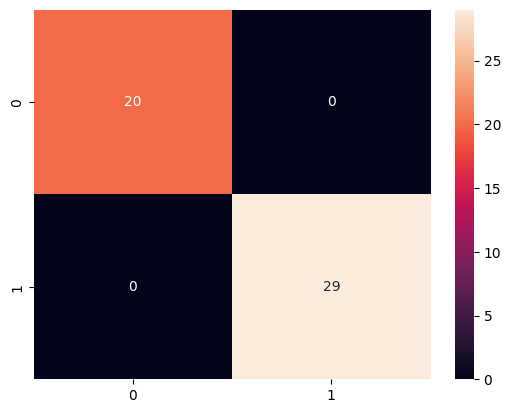

La matriz de confusión indica que el modelo tiene un rendimiento perfecto al distinguir imágenes de documentos con contenido y sin contenido, es decir no presenta ningún error en la clasificación.

Si analizamos cada valor obtenido en la matriz se tiene que:
- Verdaderos positivos (TP): Hay 20 imágenes clasificadas correctamente como documentos con contenido.

- Falsos negativos (FN): El valor es 0, lo que muestra que no se clasificaron documentos con contenido como sin contenido.

- Falsos positivos (FP): Se tiene un valor de 0. Esto indica que no se clasificaron documentos sin contenido como con contenido. No tener falsos positivos es bueno, ya que significa que no está etiquetando erróneamente imágenes de documentos en blanco o irrelevantes como documentos con contenido.

- Verdaderos negativos (TN): Hay 29 imágenes clasificados correctamente como  documentos sin contenido.

La medida escogida para evaluar el modelo es la exactitud **accuracy** se calcula como la suma de los verdaderos positivos y los verdaderos negativos dividida por el total de la muestra. 
En este caso, sería 

$\frac{{20 + 29}}{{20 + 29 + 0 + 0}} = \frac{{49}}{{49}} = 1$

Esto sugiere que el modelo tiene una tasa de aciertos del 100%, lo cual es excelente.

<img src="https://www.nomidl.com/wp-content/uploads/2022/02/image-13.png">